In [3]:
import datetime, maya, pytz, re
import pandas as pd

# Artists present per month

The objective here for me is to see the persistence of artists over the course of months in the dataset, with a `start_date` and `end_date` set and a `tolerance`

In [4]:
start_date = datetime.datetime(year=1930, month=1, day=1)
end_date = datetime.datetime(year=1940, month=1, day=1)
tolerance = datetime.timedelta(weeks=12)


# Fix timezones
timezone = pytz.timezone("UTC")
start_date = timezone.localize(start_date)
end_date = timezone.localize(end_date)


In [5]:
'''
def get_clean_df(df):
    df = df.fillna('')
    print(df[df['Category'] != '' and df['Performer'] != ''])
    
get_clean_df(df)

'''
pass

In [6]:
def get_clean_df(only_performer_and_venue=True):
    def get_performer(row):
        if row['Normalized performer'] != '':
            return row['Normalized performer']
        if row['Performer'] != '':
            return row['Performer']
        if row['Performer first-name'] != '' and row['Performer last-name'] != '':
            return row['Performer first-name'] + ' ' + row['Performer last-name']
        return ''

    def get_revue(row):
        if row['Normalized Revue Name'] != '':
            return row['Normalized Revue Name']
        if row['Revue name'] != '':
            return row['Revue name']
        return ''

    def get_venue(row, get_unique_venue=True):
        if get_unique_venue:
            if row['Unique venue'] != '':
                return row['Unique venue']

        if row['Normalized Venue'] != '':
            return row['Normalized Venue']
        if row['Venue'] != '':
            return row['Venue']
        return ''

    def get_city(row):
        if row['Normalized City'] != '':
            return row['Normalized City']
        if row['City'] != '':
            return row['City']
        return ''

    def get_source(row):
        if row['Source clean'] != '':
            return row['Source clean']
        if row['Source'] != '':
            return row['Source']
        return ''

    import maya
    from maya import pendulum

    def test_date(row, accept_only_full_dates=True):
        if accept_only_full_dates and not re.search(r'\d{4}\-\d{2}\-\d{2}', row["Date"]):
            return ''
        try:
            m = maya.parse(row["Date"]).datetime()
            return m
        except pendulum.exceptions.ParserError:
            return ''
        except ValueError:
            return ''

    drop_columns = ['Legal name', 'Alleged age',
    'Assumed birth year',
    'EIMA', 'Search (newspapers.com)',
    'Search (fulton)', 'Imported from former archive', 'Edge Comment',
    'Exclude from visualization', 'Comment on node: performer',
    'Comment on node: venue', 'Comment on node: city',
    'Comment on edge: revue', 'Blackface', 'Sepia', 'Fan dancer/Sally Rand',
    'Exotic/erotic/oriental dancer/Gypsy', 'Has image', 'Address',
    'Vaudeville Circuit/Circus', 'Unsure whether drag artist']


    df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vT0E0Y7txIa2pfBuusA1cd8X5OVhQ_D0qZC8D40KhTU3xB7McsPR2kuB7GH6ncmNT3nfjEYGbscOPp0/pub?gid=0&single=true&output=csv')

    df = df.replace('—', '')
    df = df.fillna('')


    # Set the dates
    df['Date'] = df.apply(lambda row: test_date(row), axis=1)

    # No required date
    no_date = df[(df['Date'] == '')].index
    df = df.drop(no_date)

    # Excluded
    excluded = df[df['Exclude from visualization'] == True].index
    df = df.drop(excluded)

    # Excluded
    unsure_drag = df[df['Unsure whether drag artist'] == True].index
    df = df.drop(unsure_drag)

    # Drop unnecessary columns
    df = df.drop(['Category', 'Normalized City', 'City'], axis='columns')

    # Fix performers
    df['Performer'] = df.apply(lambda row: get_performer(row), axis=1)
    df = df.drop(['Normalized performer', 'Performer first-name', 'Performer last-name'], axis='columns')

    # Fix venue
    df['Venue'] = df.apply(lambda row: get_venue(row), axis=1)
    df = df.drop(['Normalized Venue', 'Unique venue'], axis='columns')

    # Fix city *since we're using "Unique venue", we don't need city
    # df['City'] = df.apply(lambda row: get_city(row), axis=1)
    # df = df.drop(['Normalized City'], axis='columns')

    # Fix revue
    df['Revue'] = df.apply(lambda row: get_revue(row), axis=1)
    df = df.drop(['Revue name', 'Normalized Revue Name'], axis='columns')

    # Fix source
    df['Source'] = df.apply(lambda row: get_source(row), axis=1)
    df = df.drop(['Source clean'], axis='columns')

    # drop rows with none of the required data
    no_data = df[(df['Performer'] == '') & (df['Venue'] == '')].index 
    df = df.drop(no_data)

    if only_performer_and_venue:
        # drop rows with none of the required data
        no_data = df[(df['Venue'] == '') | (df['Performer'] == '')].index 
        df = df.drop(no_data)

    # Drop rest of columns
    df = df.drop(drop_columns, axis='columns')
    
    return df

In [7]:
df = get_clean_df()


# FILTER

def find_unnamed(row):
    if 'unnamed' in row.Performer.lower():
        return True
    return False

# Filtering by date
filtered_df = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]

# Filter out unnamed performers
filtered_df['Unnamed'] = filtered_df.apply(lambda row: find_unnamed(row), axis=1)
unnamed = filtered_df[filtered_df['Unnamed'] == True].index
filtered_df = filtered_df.drop(unnamed)

# Remove duplicates of subset of Date - Performer - Venue
duplicated = filtered_df[filtered_df.duplicated(subset=['Date', 'Performer', 'Venue'], keep='first')].index
filtered_df.drop(duplicated)

# Reset index
filtered_df = filtered_df.reset_index()
filtered_df = filtered_df.drop(['index'], axis='columns')

# Sort by performer
filtered_df = filtered_df.sort_values('Performer')

<ipython-input-7-8e354070654d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Unnamed'] = filtered_df.apply(lambda row: find_unnamed(row), axis=1)


In [8]:
from collections import OrderedDict

calendar = OrderedDict()
months = ['', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for performer, data in filtered_df.groupby('Performer'):
    for date in data.Date:
        year = date.year
        # month = f'{date.month:02d}'
        month = months[date.month]
        
        if not year in calendar:
            calendar[year] = {'Jan': [], 'Feb': [], 'Mar': [], 'Apr': [], 'May': [], 'Jun': [], 'Jul': [], 'Aug': [], 'Sep': [], 'Oct': [], 'Nov': [], 'Dec': []}
        if not month in calendar[year]:
            calendar[year][month] = []
        if not performer in calendar[year][month]:
            calendar[year][month].append(performer)
        
    # print([f'{x.year}-{x.month}' for x in data.Date])

In [9]:
def get_check(month, tolerance=2):
    check_years = []
    check_months = []
    
    if tolerance == 0:
        check_years = [year]
        check_months = [month]

    else:
        if month == 'Jan':
            if tolerance == 1:
                check_years = [year-1, year]
                check_months = ['Dec', 'Feb']
            elif tolerance == 2:
                check_years = [year-1, year-1, year, year]
                check_months = ['Nov', 'Dec', 'Feb', 'Mar']
            elif tolerance == 3:
                check_years = [year-1, year-1, year-1, year, year, year]
                check_months = ['Oct', 'Nov', 'Dec', 'Feb', 'Mar', 'Apr']
        elif month == 'Feb':
            if tolerance == 1:
                check_years = [year, year]
                check_months = ['Jan', 'Mar']
            elif tolerance == 2:
                check_years = [year-1, year, year, year]
                check_months = ['Dec', 'Jan', 'Mar', 'Apr']
            elif tolerance == 3:
                check_years = [year-1, year-1, year, year, year, year]
                check_months = ['Nov', 'Dec', 'Jan', 'Mar', 'Apr', 'May']
        elif month == 'Mar':
            if tolerance == 1:
                check_years = [year, year]
                check_months = ['Feb', 'Apr']
            elif tolerance == 2:
                check_years = [year, year, year, year]
                check_months = ['Jan', 'Feb', 'Apr', 'May']
            elif tolerance == 3:
                check_years = [year-1, year, year, year, year, year]
                check_months = ['Dec', 'Jan', 'Feb', 'Apr', 'May', 'Jun']
        elif month == 'Apr':
            if tolerance == 1:
                check_years = [year, year]
                check_months = ['Mar', 'May']
            elif tolerance == 2:
                check_years = [year, year, year, year]
                check_months = ['Feb', 'Mar', 'May', 'Jun']
            elif tolerance == 3:
                check_years = [year, year, year, year, year, year]
                check_months = ['Jan', 'Feb', 'Mar', 'May', 'Jun', 'Jul']
        elif month == 'May':
            if tolerance == 1:
                check_years = [year, year]
                check_months = ['Apr', 'Jun']
            elif tolerance == 2:
                check_years = [year, year, year, year]
                check_months = ['Mar', 'Apr', 'Jun', 'Jul']
            elif tolerance == 3:
                check_years = [year, year, year, year, year, year]
                check_months = ['Feb', 'Mar', 'Apr', 'Jun', 'Jul', 'Aug']
        elif month == 'Jun':
            if tolerance == 1:
                check_years = [year, year]
                check_months = ['May', 'Jul']
            elif tolerance == 2:
                check_years = [year, year, year, year]
                check_months = ['Apr', 'May', 'Jul', 'Aug']
            elif tolerance == 3:
                check_years = [year, year, year, year, year, year]
                check_months = ['Mar', 'Apr', 'May', 'Jul', 'Aug', 'Sep']
        elif month == 'Jul':
            if tolerance == 1:
                check_years = [year, year]
                check_months = ['Jun', 'Aug']
            elif tolerance == 2:
                check_years = [year, year, year, year]
                check_months = ['May', 'Jun', 'Aug', 'Sep']
            elif tolerance == 3:
                check_years = [year, year, year, year, year, year]
                check_months = ['Apr', 'May', 'Jun', 'Aug', 'Sep', 'Oct']
        elif month == 'Aug':
            if tolerance == 1:
                check_years = [year, year]
                check_months = ['Jul', 'Sep']
            elif tolerance == 2:
                check_years = [year, year, year, year]
                check_months = ['Jun', 'Jul', 'Sep', 'Oct']
            elif tolerance == 3:
                check_years = [year, year, year, year, year, year]
                check_months = ['May', 'Jun', 'Jul', 'Sep', 'Oct', 'Nov']
        elif month == 'Sep':
            if tolerance == 1:
                check_years = [year, year]
                check_months = ['Aug', 'Oct']
            elif tolerance == 2:
                check_years = [year, year, year, year]
                check_months = ['Jul', 'Aug', 'Oct', 'Nov']
            elif tolerance == 3:
                check_years = [year, year, year, year, year, year]
                check_months = ['Jun', 'Jul', 'Aug', 'Oct', 'Nov', 'Dec']
        elif month == 'Oct':
            if tolerance == 1:
                check_years = [year, year]
                check_months = ['Sep', 'Nov']
            elif tolerance == 2:
                check_years = [year, year, year, year]
                check_months = ['Aug', 'Sep', 'Nov', 'Dec']
            elif tolerance == 3:
                check_years = [year, year, year, year, year, year+1]
                check_months = ['Jul', 'Aug', 'Sep', 'Nov', 'Dec', 'Jan']
        elif month == 'Nov':
            if tolerance == 1:
                check_years = [year, year]
                check_months = ['Oct', 'Dec']
            elif tolerance == 2:
                check_years = [year, year, year, year+1]
                check_months = ['Sep', 'Oct', 'Dec', 'Jan']
            elif tolerance == 3:
                check_years = [year, year, year, year, year+1, year+1]
                check_months = ['Aug', 'Sep', 'Oct', 'Dec', 'Jan', 'Feb']
        elif month == 'Dec':
            if tolerance == 1:
                check_years = [year, year+1]
                check_months = ['Nov', 'Jan']
            elif tolerance == 2:
                check_years = [year, year, year+1, year+1]
                check_months = ['Oct', 'Nov', 'Jan', 'Feb']
            elif tolerance == 3:
                check_years = [year, year, year, year+1, year+1, year+1]
                check_months = ['Sep', 'Oct', 'Nov', 'Jan', 'Feb', 'Mar']
        else:
            raise RuntimeError('Unexpected month')
    
    return check_years, check_months

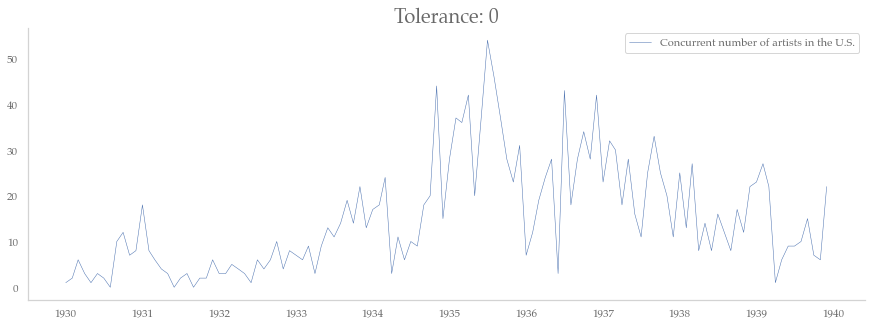

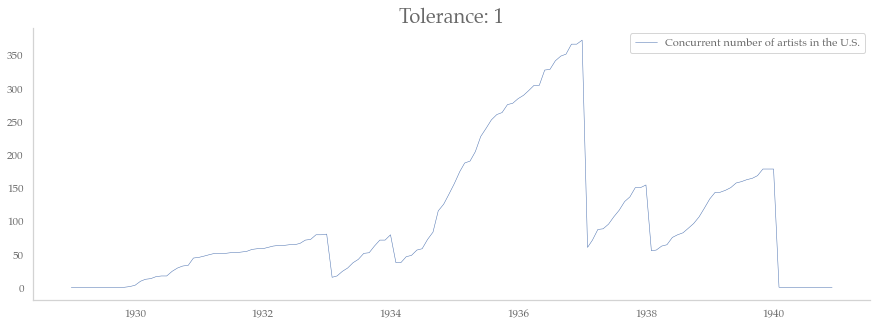

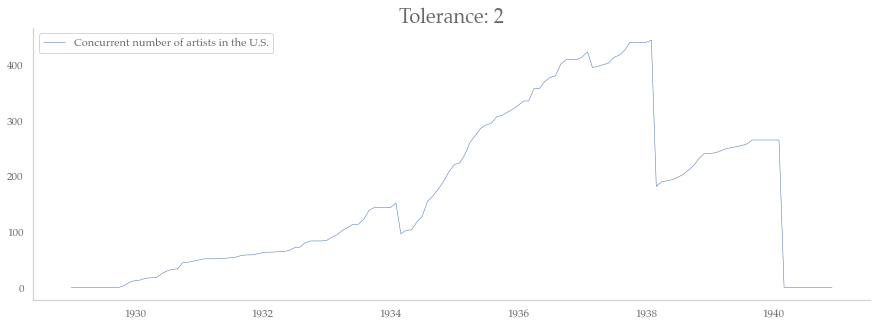

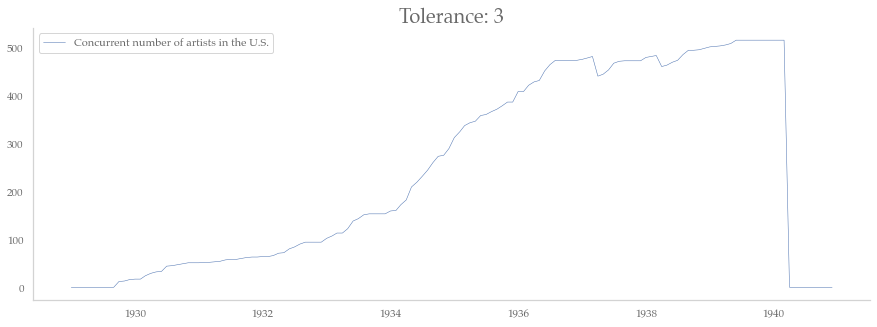

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font='Palatino',
        rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})
sns.set_context("notebook", rc={"font.size":16,
                                "axes.titlesize":20,
                                "axes.labelsize":18})


tolerances = [0,1,2,3]
calendars = {}

for tolerance in tolerances:
    filled_calendar = calendar.copy()

    for year, months in calendar.items():
        for month in months:
            check_years, check_months = get_check(month, tolerance=tolerance)

            for artist in calendar[year][month]:
                for y, m in zip(check_years, check_months):
                    if not y in filled_calendar:
                        filled_calendar[y] = {'Jan': [], 'Feb': [], 'Mar': [], 'Apr': [], 'May': [], 'Jun': [], 'Jul': [], 'Aug': [], 'Sep': [], 'Oct': [], 'Nov': [], 'Dec': []}
                    if not artist in filled_calendar[y][m]:
                        filled_calendar[y][m].append(artist)
                        
    calendars[tolerance] = OrderedDict()

    for key in sorted(filled_calendar.keys()):
        calendars[tolerance][key] = filled_calendar[key]
        
    df_summary = pd.DataFrame()

    for year, months in calendars[tolerance].items():
        for month in months:
            artists = list(set(calendars[tolerance][year][month]))
            d = {'month': month, 'year': year, 'num_artists': len(artists)}
            s = pd.Series(d, name=pd.to_datetime(f'{year}-{month}'))
            df_summary = df_summary.append(s)

    df_summary['num_artists'] = df_summary['num_artists'].astype(int)
    df_summary['year'] = df_summary['year'].astype(int)

    figure, ax1 = plt.subplots(figsize=(15,5))
    ax1.title.set_text(f'Tolerance: {tolerance}')
    ax1.plot(df_summary.index,df_summary['num_artists'],linewidth=0.5,zorder=1, label = "Concurrent number of artists in the U.S.")
    ax1.legend()

In [9]:
for year, months in calendars[2].items():
    for month in months:
        dt = datetime.datetime.strptime(f'{year} {month} 01', '%Y %b %d')
        print(dt)

1929-01-01 00:00:00
1929-02-01 00:00:00
1929-03-01 00:00:00
1929-04-01 00:00:00
1929-05-01 00:00:00
1929-06-01 00:00:00
1929-07-01 00:00:00
1929-08-01 00:00:00
1929-09-01 00:00:00
1929-10-01 00:00:00
1929-11-01 00:00:00
1929-12-01 00:00:00
1930-01-01 00:00:00
1930-02-01 00:00:00
1930-03-01 00:00:00
1930-04-01 00:00:00
1930-05-01 00:00:00
1930-06-01 00:00:00
1930-07-01 00:00:00
1930-08-01 00:00:00
1930-09-01 00:00:00
1930-10-01 00:00:00
1930-11-01 00:00:00
1930-12-01 00:00:00
1931-01-01 00:00:00
1931-02-01 00:00:00
1931-03-01 00:00:00
1931-04-01 00:00:00
1931-05-01 00:00:00
1931-06-01 00:00:00
1931-07-01 00:00:00
1931-08-01 00:00:00
1931-09-01 00:00:00
1931-10-01 00:00:00
1931-11-01 00:00:00
1931-12-01 00:00:00
1932-01-01 00:00:00
1932-02-01 00:00:00
1932-03-01 00:00:00
1932-04-01 00:00:00
1932-05-01 00:00:00
1932-06-01 00:00:00
1932-07-01 00:00:00
1932-08-01 00:00:00
1932-09-01 00:00:00
1932-10-01 00:00:00
1932-11-01 00:00:00
1932-12-01 00:00:00
1933-01-01 00:00:00
1933-02-01 00:00:00
